In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm

# Definir a semente para reprodução dos resultados
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)


In [ ]:
#Leitura de dados
df = pd.read_csv('data_per_month.csv')

In [25]:
#Visualização da base de dados
df.head()

,Year,Month,Day,Total Renewable Energy,Data Time
0,1973,1,26,219.840,1973-01-26
1,1973,2,26,197.330,1973-02-26
2,1973,3,26,218.687,1973-03-26
3,1973,4,26,209.330,1973-04-26
4,1973,5,26,215.982,1973-05-26


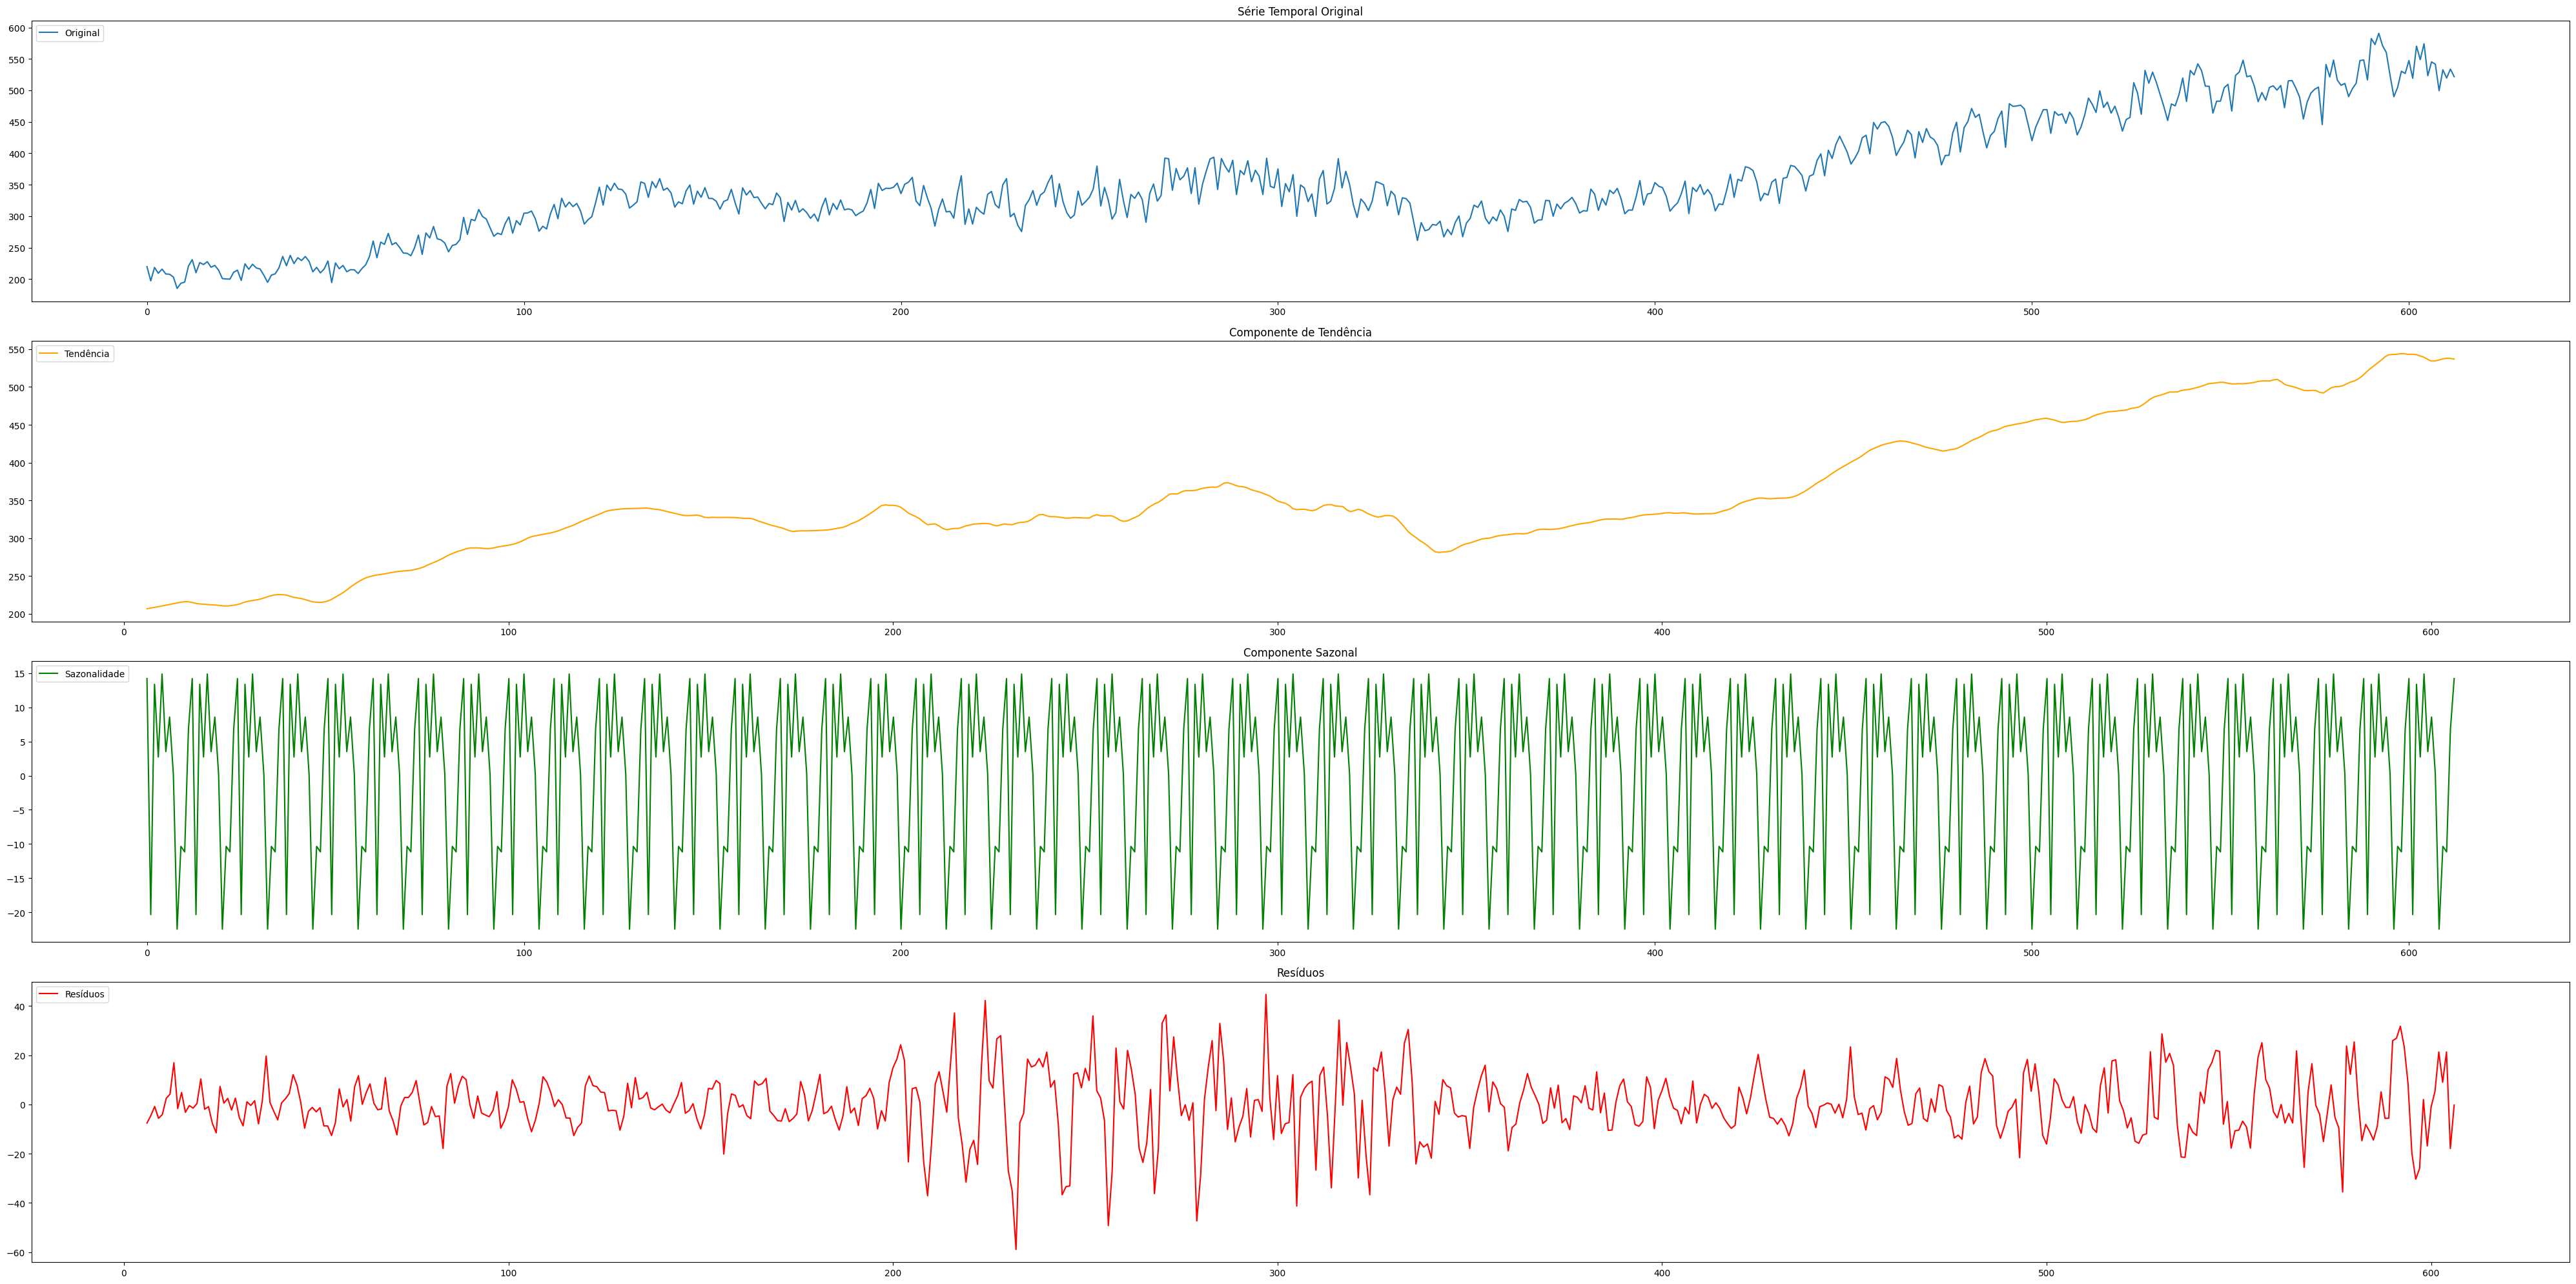

In [26]:
# Decompondo a série temporal
decomposicao = seasonal_decompose(df['Total Renewable Energy'], model='additive', period=12)  # 'period=12' para sazonalidade anual # Talvez mudar sazonalidade?

# Plotando os componentes
plt.figure(figsize=(40, 20))

plt.subplot(411)
plt.plot(df['Total Renewable Energy'], label='Original')
plt.legend(loc='upper left')
plt.title('Série Temporal Original')

plt.subplot(412)
plt.plot(decomposicao.trend, label='Tendência', color='orange')
plt.legend(loc='upper left')
plt.title('Componente de Tendência')

plt.subplot(413)
plt.plot(decomposicao.seasonal, label='Sazonalidade', color='green')
plt.legend(loc='upper left')
plt.title('Componente Sazonal')

plt.subplot(414)
plt.plot(decomposicao.resid, label='Resíduos', color='red')
plt.legend(loc='upper left')
plt.title('Resíduos')

plt.tight_layout()
plt.show()


In [27]:
from statsmodels.tsa.stattools import adfuller

data = df['Total Renewable Energy']
# Executar o teste ADF na série original
result = adfuller(data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Transformação Logarítmica
log_data = np.log(data)

# Verificando a série transformada
print(log_data)

ADF Statistic: -0.3476306025138657
p-value: 0.9184822690134047
0      5.392900
1      5.284877
2      5.387641
3      5.343912
4      5.375195
         ...   
608    6.213680
609    6.278075
610    6.253132
611    6.280057
612    6.257210
Name: Total Renewable Energy, Length: 613, dtype: float64


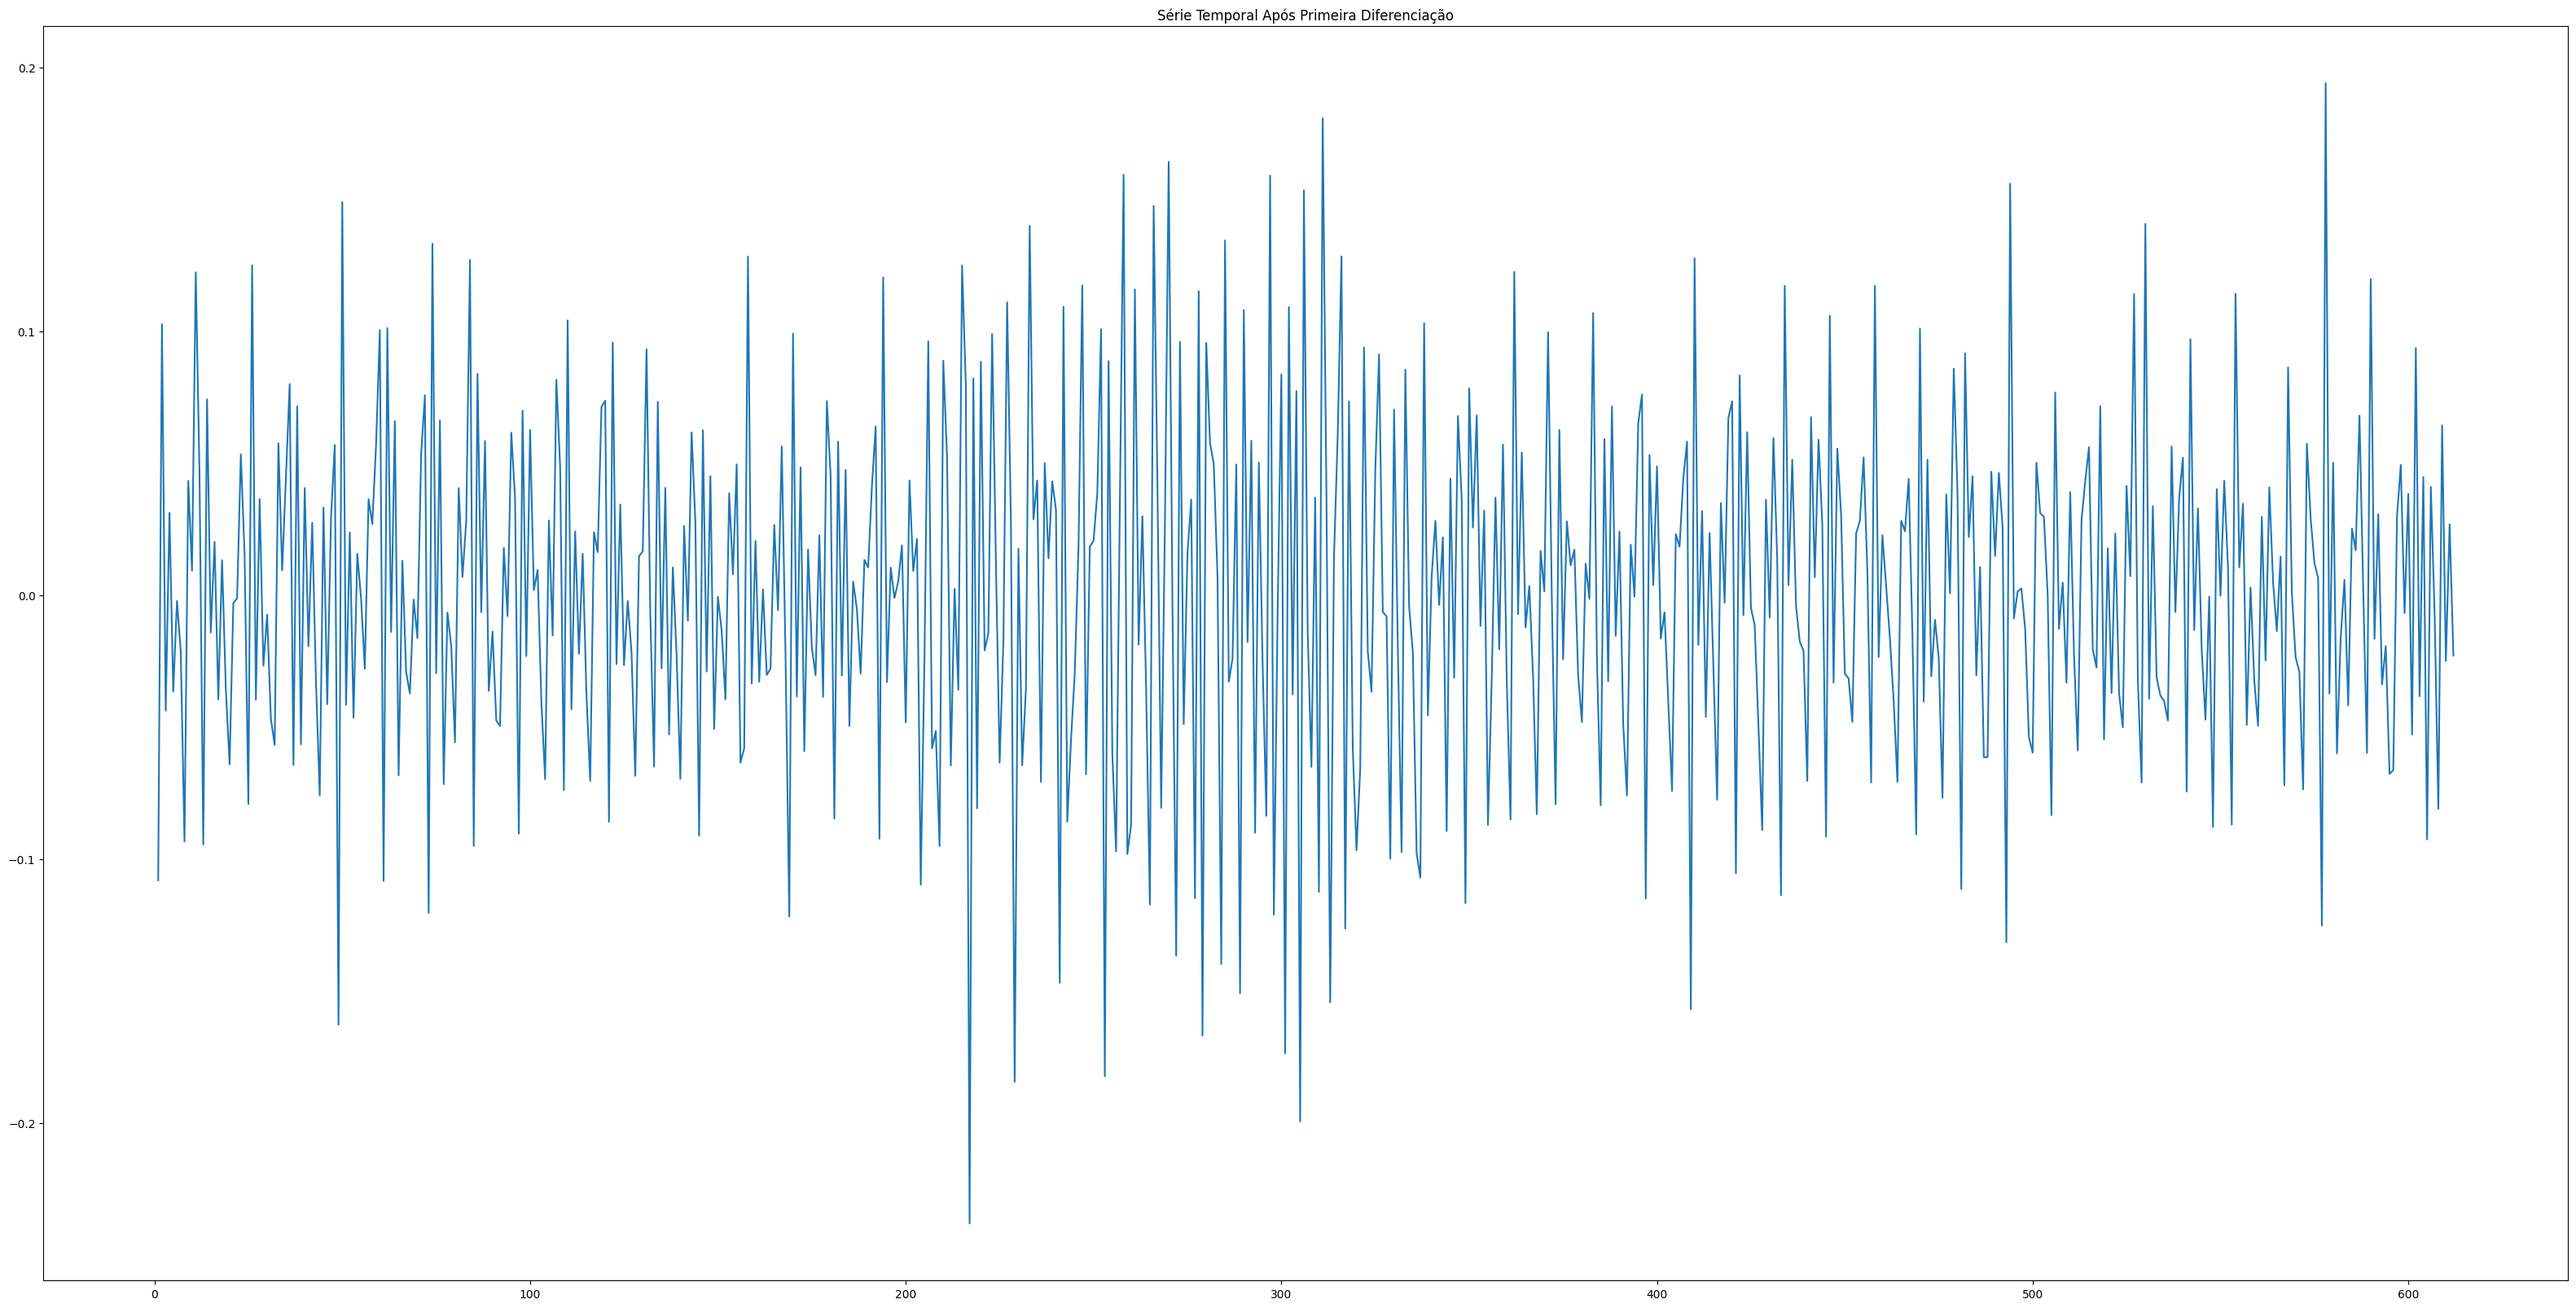

ADF Statistic: -6.850250011870762
p-value: 1.7015061255280695e-09
1     -0.108023
2      0.102764
3     -0.043730
4      0.031283
5     -0.036461
         ...   
608   -0.080959
609    0.064395
610   -0.024942
611    0.026924
612   -0.022847
Name: Total Renewable Energy, Length: 612, dtype: float64


In [28]:
# Aplicar a primeira diferenciação
initial_value = log_data.loc[0]
data_diff = log_data.diff().dropna()

# Plotar a série diferenciada
plt.figure(figsize=(40, 20))
plt.plot(data_diff)
plt.title('Série Temporal Após Primeira Diferenciação')
plt.show()

# Executar o teste ADF na série diferenciada
result_diff1 = adfuller(data_diff)
print('ADF Statistic:', result_diff1[0])
print('p-value:', result_diff1[1])

print(data_diff)

data_diff = pd.Series(data_diff)

In [30]:
from sklearn.metrics import mean_absolute_error

# Configuração da validação cruzada
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop para treinar e validar o modelo em cada divisão
for fold, (train_idx, val_idx) in enumerate(tscv.split(data_diff), 1):
    train_cross, val = data_diff.iloc[train_idx], data_diff.iloc[val_idx]
    
    # Modelo simples: previsão pela média dos dados de treino
    pred = np.mean(train_cross)  
    mae = mean_absolute_error(val, np.full_like(val, pred))  

    print(f"Fold {fold}: {len(train_cross)} treino - {len(val)} validação | MAE: {mae:.4f}")

Fold 1: 102 treino - 102 validação | MAE: 0.0426
Fold 2: 204 treino - 102 validação | MAE: 0.0761
Fold 3: 306 treino - 102 validação | MAE: 0.0514
Fold 4: 408 treino - 102 validação | MAE: 0.0464
Fold 5: 510 treino - 102 validação | MAE: 0.0439


In [31]:
train_size = int(len(data_diff) * 0.8)  # 80% treino, 20% teste
train, test = data_diff[:train_size], data_diff[train_size:]

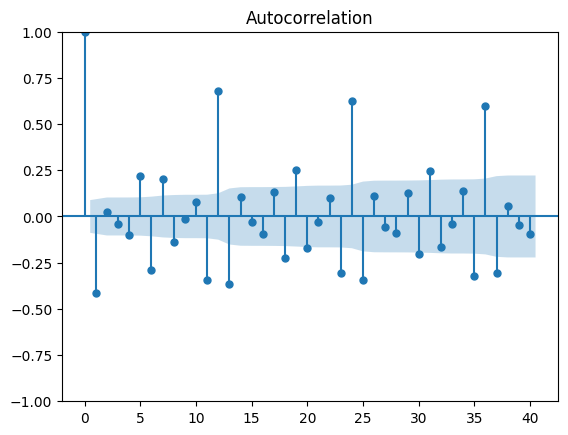

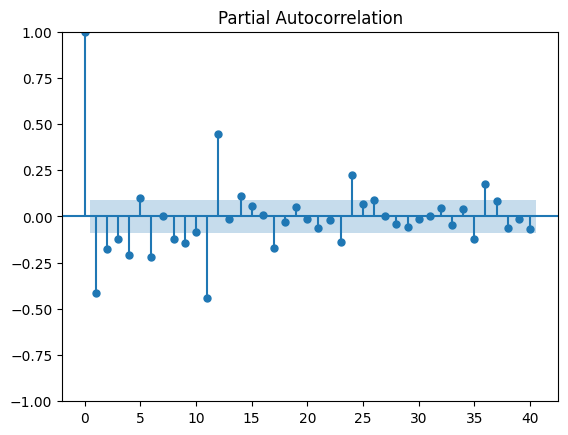

In [32]:
sm.graphics.tsa.plot_acf(train, lags=40)
sm.graphics.tsa.plot_pacf(train, lags=40)
plt.show()

C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\olihe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

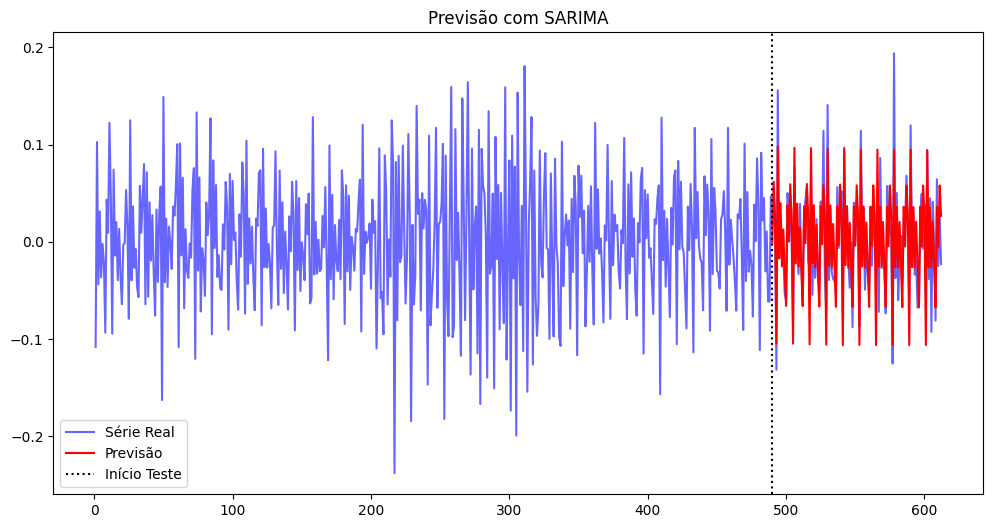

In [33]:
# Criar e treinar o modelo com os dados de treino
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(6, 1, 2, 12))
result = model.fit()

# Fazer previsões
forecast = result.predict(start=len(train), end=len(data_diff) - 1, dynamic=False)

plt.figure(figsize=(12, 6))

plt.plot(data_diff.index, data_diff, label="Série Real", color='blue', alpha=0.6)
plt.plot(test.index, forecast, label="Previsão", color='red')

plt.axvline(data_diff.index[train_size], color='black', linestyle="dotted", label="Início Teste")
plt.title("Previsão com SARIMA")
plt.legend()
plt.show()

In [34]:
# Passo 1: Reverter a diferenciação
# Pegando o último valor antes da diferenciação (usando log)
data_log = np.array(log_data)
last_value_log = data_log[-1]

# Passo 3: Reverter a diferenciação nos valores reais e nas previsões
y_true_differenced = np.array(test)  # Valores reais
y_pred_differenced = np.array(forecast)  # Previsões

# Reverter a diferenciação acumulada
y_true_log = [last_value_log]
y_pred_log = [last_value_log]

# Reconstrução da série logaritmica revertida para valores reais
for i in range(len(y_true_differenced)):
    y_true_log.append(y_true_log[-1] + y_true_differenced[i])
    y_pred_log.append(y_pred_log[-1] + y_pred_differenced[i])

# Excluir o primeiro valor, pois já foi incluído no passo anterior
y_true_log = np.array(y_true_log[1:])
y_pred_log = np.array(y_pred_log[1:])

# Passo 4: Reverter a transformação logarítmica da série principal
y_true = np.exp(y_true_log)
y_pred = np.exp(y_pred_log)

R^2: 0.7664065292709515
RMSE: 21.658824642034407
Similaridade de Cosseno: 0.9993666979749039
MAE: 17.12403604695589
Desvio Padrão (Valores Reais): 44.81305331615975
Desvio Padrão (Valores Preditos): 41.703703228848994


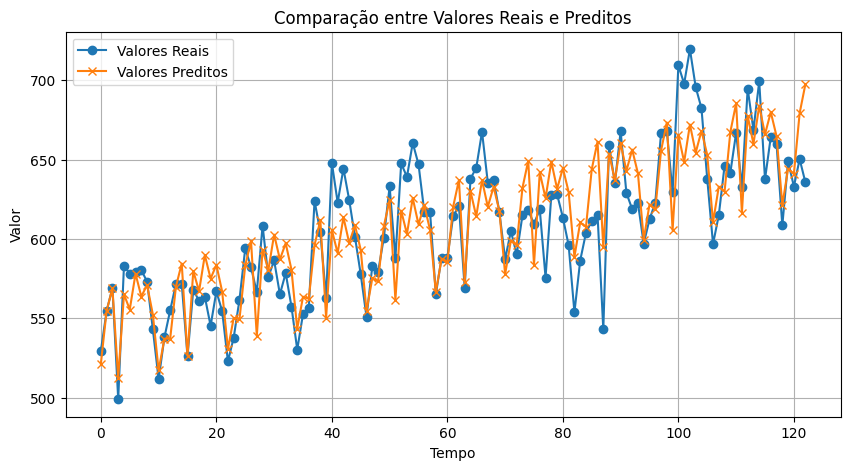

Porcentagem de erro: 2.83%
MAPE: 2.79%
Acurácia (dentro de 5% de tolerância): 83.74%


In [37]:
# Passo 5: Calcular as métricas
# Calcular R^2
r2 = r2_score(y_true, y_pred)
print(f'R^2: {r2}')

# Calcular RMSE
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
print(f'RMSE: {rmse}')

# Calcular Similaridade de Cosseno
y_true_reshaped = y_true.reshape(1, -1)
y_pred_reshaped = y_pred.reshape(1, -1)
cosine_sim = cosine_similarity(y_true_reshaped, y_pred_reshaped)[0][0]
print(f'Similaridade de Cosseno: {cosine_sim}')

# Calcular MAE (Erro Absoluto Médio)
mae = np.mean(np.abs(y_true - y_pred))
print(f'MAE: {mae}')

# Calcular Desvio Padrão
y_true_std = np.std(y_true)
y_pred_std = np.std(y_pred)
print(f'Desvio Padrão (Valores Reais): {y_true_std}')
print(f'Desvio Padrão (Valores Preditos): {y_pred_std}')

# Passo 6: Plotando o gráfico
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Valores Reais', marker='o')
plt.plot(y_pred, label='Valores Preditos', marker='x')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.title('Comparação entre Valores Reais e Preditos')
plt.legend()
plt.grid()
plt.show()

valores_reais = y_true  # Intervalo de valores fornecido

# Cálculo da média dos valores reais
media_valores_reais = sum(y_true) / len(y_true)

# Cálculo da porcentagem de erro
porcentagem_erro = (mae / media_valores_reais) * 100

# Exibição do resultado
print(f"Porcentagem de erro: {porcentagem_erro:.2f}%")


mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape:.2f}%')

# Definir um limiar de tolerância (exemplo: 5% do valor real)
tolerance = 0.05  # 5%

# Calcular a proporção de previsões dentro do limiar
correct_predictions = np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
accuracy = np.mean(correct_predictions) * 100  # Em porcentagem

print(f"Acurácia (dentro de {tolerance * 100:.0f}% de tolerância): {accuracy:.2f}%")

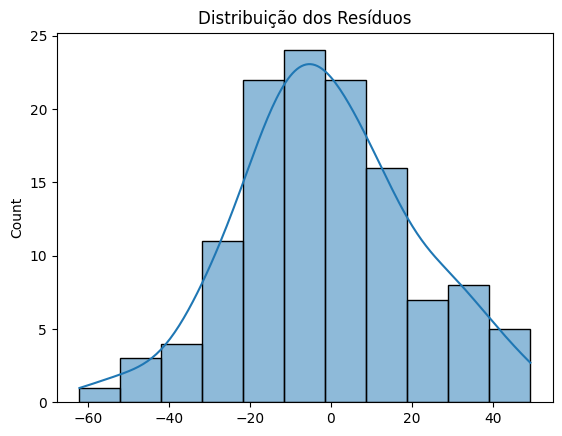

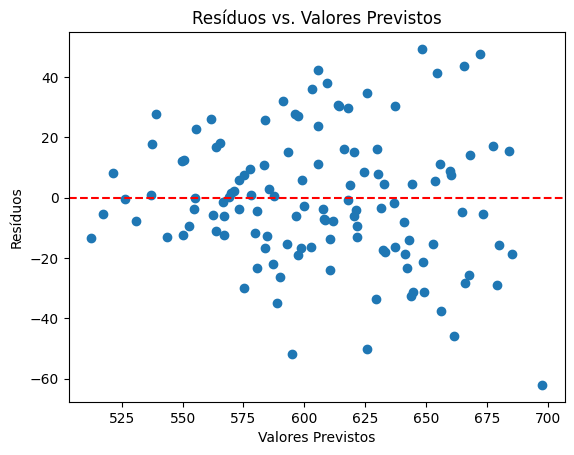

In [36]:
import seaborn as sns

# Suponha que temos y_real (dados reais) e y_pred (previsões)
residuos = y_true - y_pred

# Histograma dos resíduos
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos Resíduos")
plt.show()

# Resíduos vs. valores previstos
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs. Valores Previstos")
plt.show()
